In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
import pretrainedmodels
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from fastai.callbacks import *
np.random.seed(0)

In [3]:
torch.cuda.set_device(1)

# Data import

In [4]:
IMG_PATH = DATA_PATH/'iris'

In [5]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,0,5.1,3.5,1.4,0.2,0
1,1,4.9,3.0,1.4,0.2,0
2,2,4.7,3.2,1.3,0.2,0
3,3,4.6,3.1,1.5,0.2,0
4,4,5.0,3.6,1.4,0.2,0


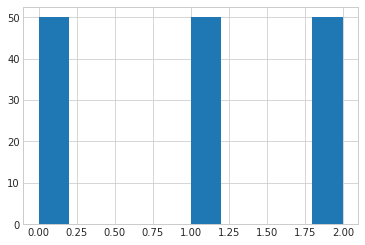

In [6]:
train_df.target.hist()

In [7]:
size = 224

In [8]:
train_df.head()

,image_name,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,0,5.1,3.5,1.4,0.2,0
1,1,4.9,3.0,1.4,0.2,0
2,2,4.7,3.2,1.3,0.2,0
3,3,4.6,3.1,1.5,0.2,0
4,4,5.0,3.6,1.4,0.2,0


In [9]:
data = ImageDataBunch.from_df(df=train_df, label_col='target', fn_col='image_name',
                              bs=16, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH/'images', folder='train', suffix='.png').normalize(imagenet_stats)

In [10]:
data

ImageDataBunch;

Train: LabelList (120 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: ../data/iris/images;

Valid: LabelList (30 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,1,0,2,0
Path: ../data/iris/images;

Test: None

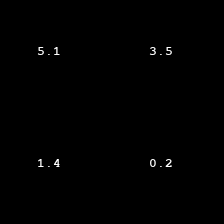

In [11]:
data.train_ds[0][0]

# Model training

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, lin_ftrs=[], bn_final=False, ps=[0])

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


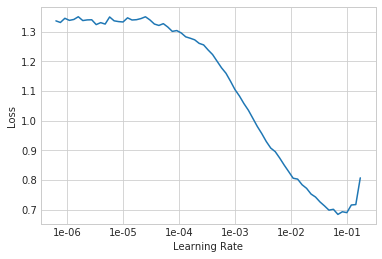

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.335430,1.462905,0.300000,00:01
1,1.095758,1.824579,0.266667,00:01
2,0.839318,2.137352,0.200000,00:01
3,0.631860,2.638420,0.200000,00:01
4,0.492670,2.190562,0.266667,00:01
5,0.401525,1.625150,0.300000,00:01
6,0.332410,1.048939,0.466667,00:01
7,0.277480,0.795751,0.533333,00:01
8,0.240039,0.810668,0.566667,00:01
9,0.208973,0.425826,0.766667,00:01


In [16]:
learn.save('stage-1')

In [17]:
learn.unfreeze()

In [18]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


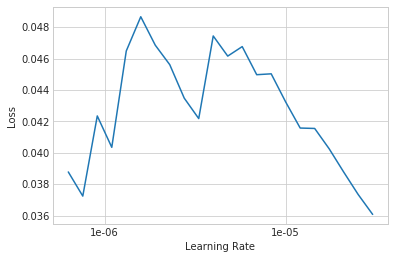

In [19]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best', mode='max')])

epoch,train_loss,valid_loss,accuracy,time
0,0.056309,0.235439,0.966667,00:01
1,0.046063,0.167325,0.966667,00:01
2,0.055359,0.125848,0.966667,00:01
3,0.050236,0.114243,0.933333,00:01
4,0.042024,0.127834,0.933333,00:01
5,0.039670,0.110304,0.966667,00:01
6,0.033755,0.117583,0.966667,00:01
7,0.029461,0.126376,0.966667,00:01
8,0.027139,0.116592,0.966667,00:01
9,0.023517,0.120522,0.966667,00:01


Better model found at epoch 0 with accuracy value: 0.9666666388511658.


In [22]:
learn.load('best');

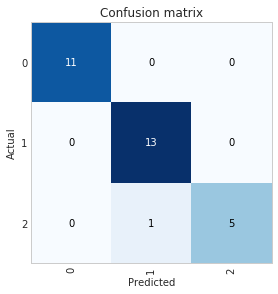

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()